In [63]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
mouse = '4139265.3'
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

df_mouse = df[df['MouseName'].str.match(mouse)]
# df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse

G:\My Drive\VR_Data\TwoTower\behavior.sqlite


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1403,4139265.3,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1405,4139265.3,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.3\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\10_02_2...
1433,4139265.3,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.3\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\12_02_2...
1455,4139265.3,15_02_2019,4,TwoTower_foraging,72,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.3\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\15_02_2...
1475,4139265.3,17_02_2019,2,TwoTower_foraging,81,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.3\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\17_02_2...
1495,4139265.3,19_02_2019,2,TwoTower_foraging,92,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.3\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\19_02_2...
1513,4139265.3,21_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.3\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\21_02_2...
1522,4139265.3,22_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-22,G:\My Drive\VR_Data\TwoTower\4139265.3\22_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\22_02_2...
1531,4139265.3,23_02_2019,2,TwoTower_foraging,93,1,CA1,2019-02-23,G:\My Drive\VR_Data\TwoTower\4139265.3\23_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\23_02_2...
1537,4139265.3,24_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-24,G:\My Drive\VR_Data\TwoTower\4139265.3\24_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.3\24_02_2...


In [176]:
sess = df_mouse.iloc[-1]
print(sess['data file'])

G:\My Drive\VR_Data\TwoTower\4139265.3\24_02_2019\TwoTower_foraging_2.sqlite


In [177]:
VRDat,C, S, A = pp.load_scan_sess(sess)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


num aberrant ttls 0.0
(32038,) (32038, 21) 105022


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


In [234]:
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat.speed._values)
S_trial_mat[np.isnan(S_trial_mat)]=0
S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,3,axis=1)

In [235]:
print(S.shape)
print(np.sum(np.isnan(S)))
print(S_trial_mat.shape)

(32038, 1634)
6763126
(120, 45, 1634)


In [236]:
effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
msort = np.argsort(effMorph)


In [237]:
S_pc = S_trial_mat[:,:,:]
# nanmask = 1-np.isnan(S_pc)

In [238]:
# S_tmat = sp.stats.zscore(np.reshape(S_pc,[S_trial_mat.shape[0],-1]),axis=-1)
S_tmat = np.reshape(S_pc,[S_trial_mat.shape[0],-1])
S_tmat = S_tmat/np.linalg.norm(S_tmat,ord=2,axis=-1)[:,np.newaxis]
# nanmask = np.reshape(nanmask,[S_trial_mat.shape[0],-1])

In [239]:
S_t_rmat = np.matmul(S_tmat,S_tmat.T) #/np.matmul(nanmask,nanmask.T)

In [240]:
print(S_t_rmat.shape)
print(S_t_rmat)

(120, 120)
[[1.         0.34517242 0.33286584 ... 0.34499092 0.36675955 0.34186115]
 [0.34517242 1.         0.39118137 ... 0.41481755 0.39879211 0.40429274]
 [0.33286584 0.39118137 1.         ... 0.43787115 0.41776494 0.38981693]
 ...
 [0.34499092 0.41481755 0.43787115 ... 1.         0.42082478 0.56635333]
 [0.36675955 0.39879211 0.41776494 ... 0.42082478 1.         0.40645407]
 [0.34186115 0.40429274 0.38981693 ... 0.56635333 0.40645407 1.        ]]


In [241]:
import sklearn as sk
import sklearn.cluster as clust


In [242]:
score = []
for c in range(2,10):
    spectclust = clust.SpectralClustering(n_clusters=c,affinity='precomputed')
    labels = spectclust.fit_predict(S_t_rmat)
    
    
#     aggclust = clust.AgglomerativeClustering(n_clusters=c,affinity='cosine',linkage="average")
#     aggclust.fit(S_tmat)
#     s=sk.metrics.silhouette_score(S_tmat,aggclust.labels_,metric='cosine')
    s=sk.metrics.silhouette_score(S_tmat,labels,metric='cosine')
    score.append(np.round(100.*s))
    print(s*100.)
    

c = np.argmax(score)+2
# aggclust = clust.AgglomerativeClustering(n_clusters=c,affinity='cosine',linkage="average")
# aggclust.fit(S_tmat)
spectclust = clust.SpectralClustering(n_clusters=c,affinity='precomputed')
spectclust.fit(S_t_rmat)

19.787160520792828
16.835681307508516
13.489534884631949
9.104638241250811
8.933565857017276
8.672075610538581
8.740729470690288
9.668108841581931


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
          n_neighbors=10, random_state=None)

2


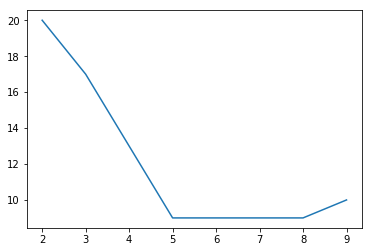

In [243]:
f,ax= plt.subplots()
ax.plot(np.arange(2,10),score)
print(c)

In [244]:
# clustsort = np.argsort(aggclust.labels_)
# clustsort = np.argsort(spectclust.labels_)

# sort clusters by average morph values 
clustmean = np.array([effMorph[spectclust.labels_==i].mean() for i in range(c)])
clusterOrder = np.argsort(clustmean)
labels = np.zeros(effMorph.shape)

for i,cl in enumerate(clusterOrder.tolist()):
    labels[spectclust.labels_==cl]=i
    
clustsort = np.argsort(labels)  


[]

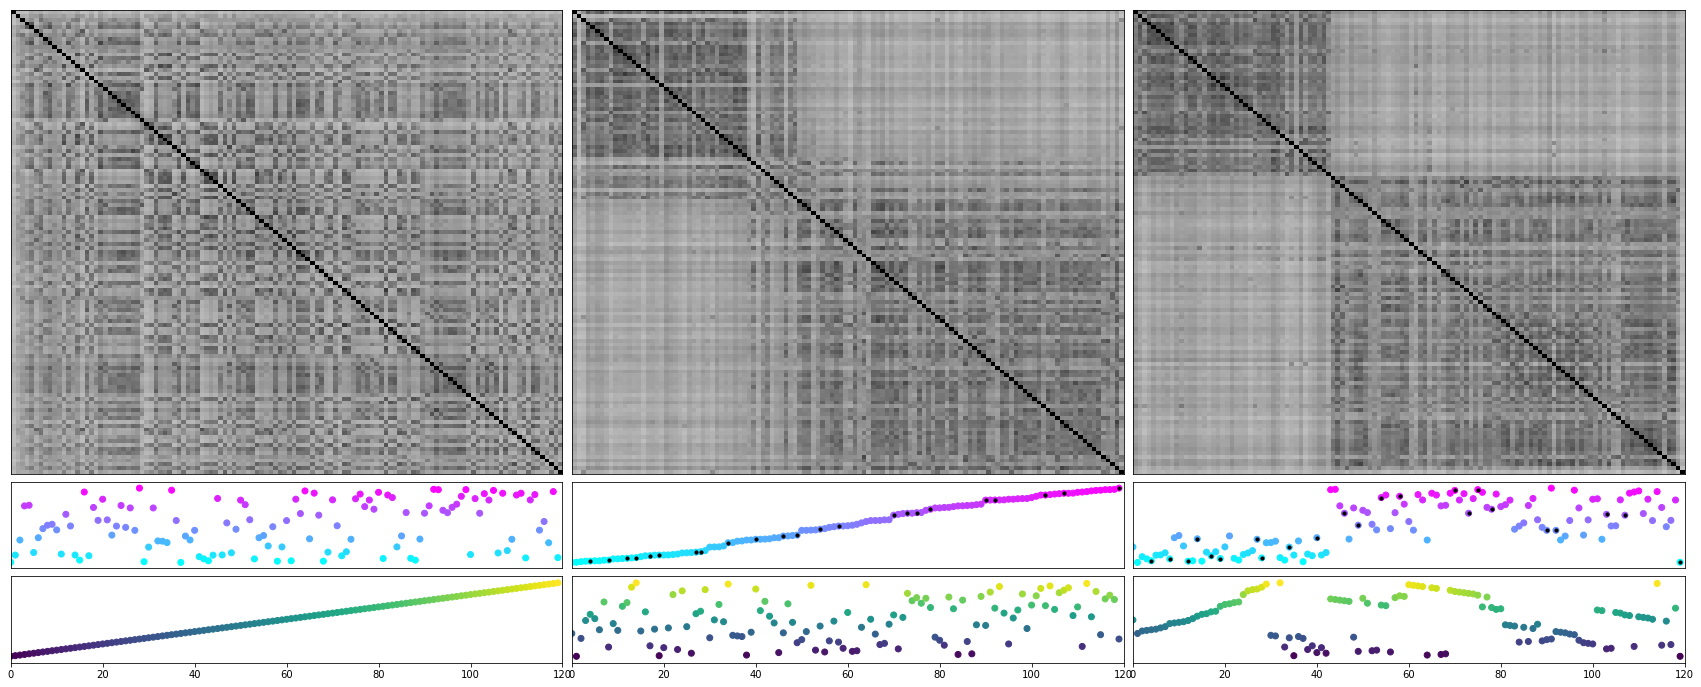

In [246]:
import matplotlib.gridspec as gridspec
f = plt.figure(figsize=[30,12])
gs = gridspec.GridSpec(14,30)
x=np.arange(effMorph.size)
rmask = trial_info['rewards']==0
tnumber = np.arange(x.shape[0])/x.shape[0]
vmax = .9
# f,ax = plt.subplots(2,3,figsize=[20,10],sharex=True)
ax = f.add_subplot(gs[:10,:10])
ax.imshow(S_t_rmat,cmap='Greys',vmin=0,vmax=vmax,aspect='auto')
ax.set_yticks([])
ax.set_xticks([])
ax = f.add_subplot(gs[10:12,:10])
ax.scatter(x,effMorph,c=effMorph,cmap='cool')
ax.set_xlim([0,x.shape[0]])
ax.set_yticks([])
ax.set_xticks([])
ax = f.add_subplot(gs[12:,:10])
ax.scatter(x,tnumber,c=tnumber,cmap='viridis')
ax.set_xlim([0,x.shape[0]])
ax.set_yticks([])
# ax[0,0].imshow(S_t_rmat,cmap='Greys',vmin=0,vmax=.5,aspect='auto')
S_agg_sort = S_t_rmat[clustsort,:]
S_agg_sort = S_agg_sort[:,clustsort]
S_rmat_sort = S_t_rmat[msort,:]
S_rmat_sort = S_rmat_sort[:,msort]


ax = f.add_subplot(gs[:10,10:20])
ax.imshow(S_rmat_sort,cmap='Greys',vmin=0,vmax=vmax,aspect='auto')
ax.set_yticks([])
ax.set_xticks([])
ax = f.add_subplot(gs[10:12,10:20])
ax.scatter(x,effMorph[msort],c=effMorph[msort],cmap='cool')
ax.scatter(x[rmask],effMorph[msort[rmask]],c='black',s=10)
ax.set_xlim([0,x.shape[0]])
ax.set_yticks([])
ax.set_xticks([])
ax = f.add_subplot(gs[12:,10:20])
ax.scatter(x,tnumber[msort],c=tnumber[msort],cmap='viridis')
ax.set_xlim([0,x.shape[0]])
ax.set_yticks([])


ax = f.add_subplot(gs[:10,20:])
ax.imshow(S_agg_sort,cmap='Greys',vmin=0,vmax=vmax,aspect='auto')
ax.set_yticks([])
ax.set_xticks([])
ax = f.add_subplot(gs[10:12,20:])
ax.scatter(x,effMorph[clustsort],c=effMorph[clustsort],cmap='cool')
ax.set_yticks([])
ax.set_xticks([])
# tmpeff = np.copy(effMorph[1:])
# ax.scatter(x[:-1],tmpeff[clustsort[1:]],c=tmpeff[clustsort[1:]],cmap='cool')
ax.scatter(x[rmask],effMorph[clustsort[rmask]],c='black',s=10)
ax.set_xlim([0,x.shape[0]])
ax = f.add_subplot(gs[12:,20:])
ax.scatter(x,tnumber[clustsort],c=tnumber[clustsort],cmap='viridis')
ax.set_xlim([0,x.shape[0]])
ax.set_yticks([])


In [190]:
lem = sk.manifold.SpectralEmbedding(affinity='precomputed',n_components=3)


In [191]:
X = lem.fit_transform(S_t_rmat)

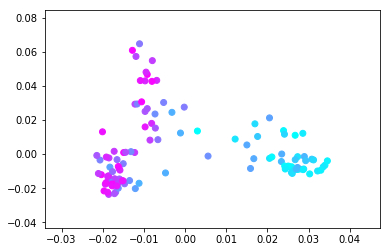

In [192]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:,0],X[:,1],X[:,2],c=effMorph,cmap='cool')

f,ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],c=effMorph,cmap='cool')



In [193]:
S[np.isnan(S)]=0
S_sm = sp.ndimage.filters.gaussian_filter1d(S,10,axis=0)

In [194]:
S_sm_n = S_sm/(np.linalg.norm(S_sm,ord=2,axis=1)[:,np.newaxis]+.001)

In [195]:
print(S_sm_n.shape)

(32038, 1634)


In [196]:
S_cos = np.matmul(S_sm_n,S_sm_n.T)

In [197]:
print(S_cos.shape)

(32038, 32038)


In [198]:
lem = sk.manifold.SpectralEmbedding(affinity='precomputed',n_components=5)
X = lem.fit_transform(S_cos+.0001)


In [199]:
print(X.shape)

(32038, 5)


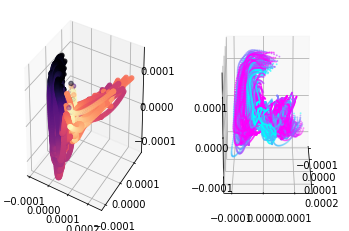

In [219]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
p_ax = fig.add_subplot(121, projection='3d')
mask = (VRDat['pos']._values>0) & (VRDat['morph']._values>=0)
p_ax.scatter(X[mask,0],X[mask,1],X[mask,2],c=VRDat['pos']._values[mask],cmap='magma')
m_ax = fig.add_subplot(122, projection='3d')
m_ax.scatter(X[mask,0],X[mask,1],X[mask,2],c=VRDat['morph']._values[mask],s=1,cmap='cool')
m_ax.view_init(20,0)
